In [144]:
import xarray as xr
import matplotlib.pyplot as plt
from stompy.grid import unstructured_grid
from stompy import utils
import numpy as np
import os
%matplotlib notebook

In [62]:
# Trying to better understand the z-layer output
run_dir='run_salt_20160520-v09'
out_dir=run_dir+"/DFM_OUTPUT_flowfm"

In [64]:
# look at proc 3 and 15, where the inflows are
ds=xr.open_dataset(out_dir+"/flowfm_0015_map.nc")

In [65]:
ds

<xarray.Dataset>
Dimensions:                      (laydim: 1, nBndLink: 601, nFlowElem: 5197, nFlowElemContourPts: 4, nFlowLink: 8471, nFlowLinkPts: 2, nNetElem: 5197, nNetElemMaxNode: 4, nNetLink: 9065, nNetLinkContourPts: 4, nNetLinkPts: 2, nNetNode: 3870, nmesh2d_EnclosureInstance: 1, nmesh2d_EnclosureParts: 2, nmesh2d_EnclosurePoints: 528, time: 193, wdim: 2)
Coordinates:
    NetNode_x                    (nNetNode) float64 ...
    NetNode_y                    (nNetNode) float64 ...
    FlowElem_xcc                 (nFlowElem) float64 ...
    FlowElem_ycc                 (nFlowElem) float64 ...
    FlowLink_xu                  (nFlowLink) float64 ...
    FlowLink_yu                  (nFlowLink) float64 ...
  * time                         (time) datetime64[ns] 2016-05-20 ... 2016-05-28
Dimensions without coordinates: laydim, nBndLink, nFlowElem, nFlowElemContourPts, nFlowLink, nFlowLinkPts, nNetElem, nNetElemMaxNode, nNetLink, nNetLinkContourPts, nNetLinkPts, nNetNode, nmesh2d_EnclosureInstance, nmesh2d_EnclosureParts, nmesh2d_EnclosurePoints, wdim
Data variables:
    mesh2d_enc_x                 (nmesh2d_EnclosurePoints) float64 ...
    mesh2d_enc_y                 (nmesh2d_EnclosurePoints) float64 ...
    mesh2d_enc_node_count        (nmesh2d_EnclosureInstance) int32 ...
    mesh2d_enc_part_node_count   (nmesh2d_EnclosureParts) int32 ...
    mesh2d_enc_interior_ring     (nmesh2d_EnclosureParts) int32 ...
    mesh2d_enclosure_container   float32 ...
    Mesh2D                       int32 ...
    projected_coordinate_system  int32 ...
    NetNode_z                    (nNetNode) float64 ...
    NetLink                      (nNetLink, nNetLinkPts) int32 ...
    NetLinkType                  (nNetLink) int32 ...
    NetElemNode                  (nNetElem, nNetElemMaxNode) float64 ...
    NetElemLink                  (nNetElem, nNetElemMaxNode) int32 ...
    NetLinkContour_x             (nNetLink, nNetLinkContourPts) float64 ...
    NetLinkContour_y             (nNetLink, nNetLinkContourPts) float64 ...
    NetLink_xu                   (nNetLink) float64 ...
    NetLink_yu                   (nNetLink) float64 ...
    BndLink                      (nBndLink) int32 ...
    FlowElem_zcc                 (nFlowElem) float64 ...
    FlowElem_bac                 (nFlowElem) float64 ...
    FlowElem_xzw                 (nFlowElem) float64 ...
    FlowElem_yzw                 (nFlowElem) float64 ...
    FlowElemContour_x            (nFlowElem, nFlowElemContourPts) float64 ...
    FlowElemContour_y            (nFlowElem, nFlowElemContourPts) float64 ...
    FlowElem_bl                  (nFlowElem) float64 ...
    ElemLink                     (nNetLink, nNetLinkPts) int32 ...
    FlowLink                     (nFlowLink, nFlowLinkPts) int32 ...
    FlowLinkType                 (nFlowLink) int32 ...
    FlowLink_lonu                (nFlowLink) float64 ...
    FlowLink_latu                (nFlowLink) float64 ...
    FlowElemDomain               (nFlowElem) int32 ...
    FlowLinkDomain               (nFlowLink) int32 ...
    FlowElemGlobalNr             (nFlowElem) int32 ...
    LayCoord_cc                  (laydim) float64 ...
    LayCoord_w                   (wdim) float64 ...
    timestep                     (time) timedelta64[ns] ...
    s1                           (time, nFlowElem) float64 ...
    waterdepth                   (time, nFlowElem) float64 ...
    numlimdt                     (time, nFlowElem) float64 ...
    taus                         (time, nFlowElem) float64 ...
    unorm                        (time, nFlowLink, laydim) float64 ...
    u0                           (time, nFlowLink, laydim) float64 ...
    q1                           (time, nFlowLink, laydim) float64 ...
    viu                          (time, nFlowLink, laydim) float64 ...
    diu                          (time, nFlowLink, laydim) float64 ...
    ucz                          (time, nFlowElem, laydim) float64 ...
    ucxa                         (time, nF

In [66]:
# Layer information in there:
# ds.dims['laydim'] is 10
# wdim is 11
# LayCoord_{cc,w} are meaningless.

In [28]:
# ucz is a layer-centered vertical velocity.
# Take a sample element at the last time step:
# layers start at bed
t=-1
if 0==np.sum(np.isnan(ds['ucz'].isel(laydim=9,time=t).values)):
    print("All top layer cells have finite ucz")
if 0==np.sum(np.isnan(ds['ww1'].isel(wdim=10,time=t).values)):
    print("All top layer cells have finite surface ww1")
if 0==np.sum(np.isnan(ds['ww1'].isel(wdim=9,time=t).values)):
    print("All top layer cells have finite sub-surface ww1")
if 0<np.sum(np.isnan(ds['ww1'].isel(wdim=8,time=t).values)):
    print("Some cells have nan sub-surface ww1")
    
    

elt=10
print(ds['ucz'].isel(time=t,nFlowElem=elt).values)
print(ds['ww1'].isel(time=t,nFlowElem=elt).values)

[           nan            nan            nan            nan
            nan            nan            nan            nan
            nan 1.71407016e-05]
[           nan            nan            nan            nan
            nan            nan            nan            nan
            nan 0.00000000e+00 2.27844134e-05]
All top layer cells have finite ucz
All top layer cells have finite surface ww1
All top layer cells have finite sub-surface ww1
Some cells have nan sub-surface ww1


In [39]:
nlayers=np.isfinite(ds['ucz'].isel(time=t)).sum(dim='laydim')
print(f"Number of layers (w/finite ucz) ranges from {nlayers.values.min()} to {nlayers.values.max()}")

Number of layers (w/finite ucz) ranges from 1 to 10


In [35]:
for proc in range(16):
    ds_proc=xr.open_dataset(out_dir+f"/flowfm_{proc:04d}_map.nc")
    nlayers=np.isfinite(ds_proc['ucz'].isel(time=t)).sum(dim='laydim')
    print(f"[p={proc:02d}] Number of layers (w/finite ucz) ranges from {nlayers.values.min()} to {nlayers.values.max()}")
    ds_proc.close()

# proc 3 and 15 have cells with 10 layers.


[p=00] Number of layers (w/finite ucz) ranges from 1 to 6
[p=01] Number of layers (w/finite ucz) ranges from 1 to 5
[p=02] Number of layers (w/finite ucz) ranges from 1 to 1
[p=03] Number of layers (w/finite ucz) ranges from 1 to 10
[p=04] Number of layers (w/finite ucz) ranges from 1 to 5
[p=05] Number of layers (w/finite ucz) ranges from 1 to 3
[p=06] Number of layers (w/finite ucz) ranges from 1 to 3
[p=07] Number of layers (w/finite ucz) ranges from 1 to 3
[p=08] Number of layers (w/finite ucz) ranges from 1 to 5
[p=09] Number of layers (w/finite ucz) ranges from 1 to 6
[p=10] Number of layers (w/finite ucz) ranges from 1 to 6
[p=11] Number of layers (w/finite ucz) ranges from 1 to 5
[p=12] Number of layers (w/finite ucz) ranges from 1 to 8
[p=13] Number of layers (w/finite ucz) ranges from 1 to 3
[p=14] Number of layers (w/finite ucz) ranges from 1 to 7
[p=15] Number of layers (w/finite ucz) ranges from 1 to 10


In [67]:
g=unstructured_grid.UnstructuredGrid.read_ugrid(ds)

In [59]:
ds # check out NetNode_z, FlowElem_zcc, FlowElem_bl

<xarray.Dataset>
Dimensions:                      (laydim: 1, nBndLink: 601, nFlowElem: 5197, nFlowElemContourPts: 4, nFlowLink: 8471, nFlowLinkPts: 2, nNetElem: 5197, nNetElemMaxNode: 4, nNetLink: 9065, nNetLinkContourPts: 4, nNetLinkPts: 2, nNetNode: 3870, nmesh2d_EnclosureInstance: 1, nmesh2d_EnclosureParts: 2, nmesh2d_EnclosurePoints: 528, time: 84, wdim: 2)
Coordinates:
    NetNode_x                    (nNetNode) float64 5.534e+05 ... 5.535e+05
    NetNode_y                    (nNetNode) float64 4.124e+06 ... 4.123e+06
    FlowElem_xcc                 (nFlowElem) float64 5.541e+05 ... 5.529e+05
    FlowElem_ycc                 (nFlowElem) float64 4.123e+06 ... 4.125e+06
    FlowLink_xu                  (nFlowLink) float64 5.541e+05 ... 5.541e+05
    FlowLink_yu                  (nFlowLink) float64 4.123e+06 ... 4.123e+06
  * time                         (time) datetime64[ns] 2016-05-20 ... 2016-06...
Dimensions without coordinates: laydim, nBndLink, nFlowElem, nFlowElemContourPts, nFlowLink, nFlowLinkPts, nNetElem, nNetElemMaxNode, nNetLink, nNetLinkContourPts, nNetLinkPts, nNetNode, nmesh2d_EnclosureInstance, nmesh2d_EnclosureParts, nmesh2d_EnclosurePoints, wdim
Data variables:
    mesh2d_enc_x                 (nmesh2d_EnclosurePoints) float64 5.541e+05 ...
    mesh2d_enc_y                 (nmesh2d_EnclosurePoints) float64 4.123e+06 ...
    mesh2d_enc_node_count        (nmesh2d_EnclosureInstance) int32 528
    mesh2d_enc_part_node_count   (nmesh2d_EnclosureParts) int32 452 76
    mesh2d_enc_interior_ring     (nmesh2d_EnclosureParts) int32 0 0
    mesh2d_enclosure_container   float32 9.969e+36
    Mesh2D                       int32 -2147483647
    projected_coordinate_system  int32 -2147483647
    NetNode_z                    (nNetNode) float64 2.315 3.286 ... 3.862 3.781
    NetLink                      (nNetLink, nNetLinkPts) int32 2234 ... 2557
    NetLinkType                  (nNetLink) int32 2 2 2 2 2 2 2 ... 2 2 2 2 2 2
    NetElemNode                  (nNetElem, nNetElemMaxNode) float64 2.225e+0...
    NetElemLink                  (nNetElem, nNetElemMaxNode) int32 7 ... -214...
    NetLinkContour_x             (nNetLink, nNetLinkContourPts) float64 5.541...
    NetLinkContour_y             (nNetLink, nNetLinkContourPts) float64 4.123...
    NetLink_xu                   (nNetLink) float64 5.541e+05 ... 5.529e+05
    NetLink_yu                   (nNetLink) float64 4.123e+06 ... 4.125e+06
    BndLink                      (nBndLink) int32 1 2 4 6 ... 9056 9061 9064
    FlowElem_zcc                 (nFlowElem) float64 -0.0 -0.0 ... -1.449 -1.459
    FlowElem_bac                 (nFlowElem) float64 11.37 12.27 ... 127.0 141.9
    FlowElem_xzw                 (nFlowElem) float64 5.541e+05 ... 5.529e+05
    FlowElem_yzw                 (nFlowElem) float64 4.123e+06 ... 4.125e+06
    FlowElemContour_x            (nFlowElem, nFlowElemContourPts) float64 5.5...
    FlowElemContour_y            (nFlowElem, nFlowElemContourPts) float64 4.1...
    FlowElem_bl                  (nFlowElem) float64 0.0 0.0 0.0 ... 1.449 1.459
    ElemLink                     (nNetLink, nNetLinkPts) int32 1 0 ... 5197 5195
    FlowLink                     (nFlowLink, nFlowLinkPts) int32 1 2 ... 5204 22
    FlowLinkType                 (nFlowLink) int32 2 2 2 2 2 2 2 ... 2 2 2 2 2 2
    FlowLink_lonu                (nFlowLink) float64 9.969e+36 ... 9.969e+36
    FlowLink_latu                (nFlowLink) float64 9.969e+36 ... 9.969e+36
    FlowElemDomain               (nFlowElem) int32 15 15 15 15 ... 14 14 14 14
    FlowLinkDomain               (nFlowLink) int32 15 15 15 15 ... 15 15 15 15
    FlowElemGlobalNr             (nFlowElem) int32 71264 71265 ... 20974 20975
    LayCoord_cc                  (laydim) float64 9.969e+36
    LayCoord_w                   (wdim) float64 9.969e+36 9.969e+36
    timestep                     (time) timedelta64[ns] 00:00:01 ... 00:00:00...
    s1                           (time, nFlowElem) float64 ...
    waterdepth   

<IPython.core.display.Javascript object>


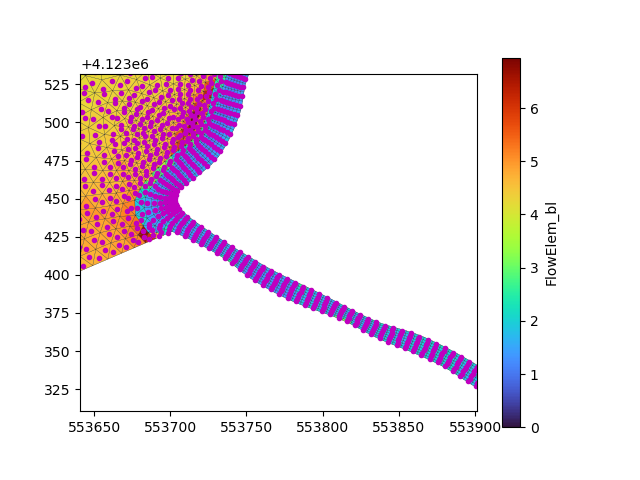

In [61]:
plt.figure()
g.plot_edges(lw=0.2,color='k')
v='FlowElem_bl'
ccoll=g.plot_cells(values=ds[v].values,cmap='turbo')
plt.plot( ds.FlowElem_xcc.values, ds.FlowElem_ycc.values, 'm.')
plt.colorbar(ccoll,label=v)

In [411]:
from stompy.grid import multi_ugrid
import six
six.moves.reload_module(multi_ugrid)

<module 'stompy.grid.multi_ugrid' from '/home/rusty/src/stompy/stompy/grid/multi_ugrid.py'>

In [424]:
mu=multi_ugrid.MultiUgrid(paths="run_salt_20160520-v44/DFM_OUTPUT_flowfm/*_map.nc",
                          cleanup_dfm=True)

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

In [425]:
mu.reload()
print("Evolution of timesteps")
mu.dss[0].timestep/np.timedelta64(1,'s')

Evolution of timesteps


<xarray.DataArray 'timestep' (time: 7)>
array([1.00000000e+00, 1.32461798e-01, 1.58213770e-02, 2.17939270e-02,
       3.46609940e-02, 3.98796486e-01, 3.35068000e-04])
Coordinates:
  * time     (time) datetime64[ns] 2016-05-20 ... 2016-05-20T00:28:09.776995709

<IPython.core.display.Javascript object>


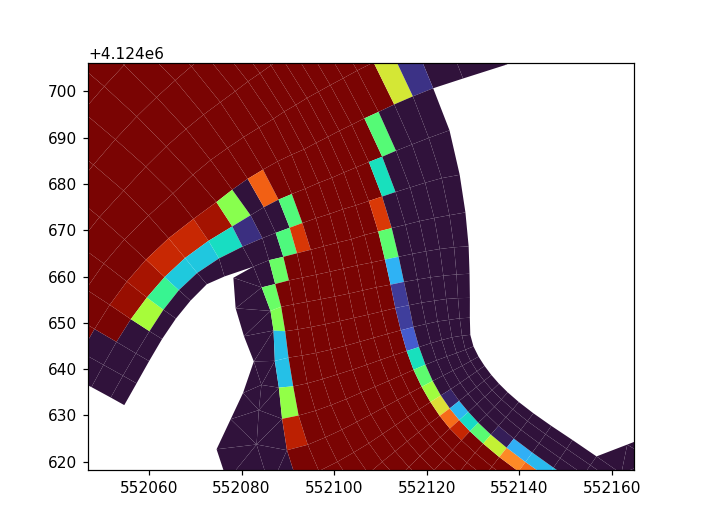

(552046.8017776366, 552164.7249865616, 4124618.199712799, 4124706.0715233204)

In [487]:
plt.figure()
#mu.grid.plot_cells(values=mu['s1'].isel(time=-1),cmap='turbo',clim=[1.55,1.60])
mu.grid.plot_cells(values=mu['waterdepth'].isel(time=-1),cmap='turbo',clim=[0,0.5])

plt.axis('tight')
plt.axis('equal')
plt.axis((552046.8017776366, 552164.7249865616, 4124618.199712799, 4124706.0715233204))


In [479]:
plt.axis()

(552046.8017776366, 552164.7249865616, 4124618.199712799, 4124706.0715233204)

<IPython.core.display.Javascript object>


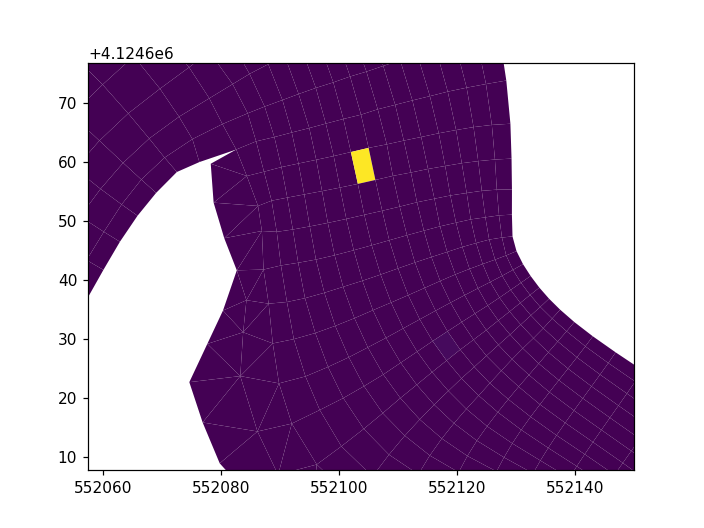

(551856.9727258877, 554172.3087989085, 4122619.5656163436, 4125496.2586278315)

In [435]:
plt.figure()
mu.grid.plot_cells(values=mu['numlimdt'].isel(time=-1).values-mu['numlimdt'].isel(time=-2).values)
plt.axis('tight')
plt.axis('equal')

In [436]:
# from run 44, problem cell at ocean BC
# This is the ocean BC cell, that's limiting earlier on:
# cell_center=np.array([ 552005.1, 4124739.5 ])
# And this the mouth cell that's problematic over the last pair of
# map outputs
cell_center=np.array([ 552104.0, 4124659.3 ])

c_global=mu.grid.select_cells_nearest(cell_center)
c_global
mu.build_cell_g2l()
proc,c_local=mu.cell_g2l[c_global] 

In [457]:
# Trying to understand what's up with the time-limiting cell
# From visit, this is block 11, zone 4828, at point 552597, 4.12381e+06
# good match.
time=6

cell_ds=mu.dss[proc].isel(nFlowElem=c_local)
print("numlimdt:",cell_ds.numlimdt.values) # 17669 by the end.
print("ucx")
display(cell_ds.ucx.to_dataframe()['ucx'].unstack('laydim'))
print("ucy")
display(cell_ds.ucy.to_dataframe()['ucy'].unstack('laydim'))
print("ww1")
display(cell_ds.ww1.to_dataframe()['ww1'].unstack('wdim'))
print("FlowElem_bl:",cell_ds.FlowElem_bl.values) # 1.249898
print("s1(time): ",cell_ds.s1.values)

numlimdt: [0.000e+00 1.000e+00 1.000e+00 1.772e+03 1.772e+03 2.031e+03 2.883e+03]
ucx


laydim,0,1,2,3,4,5,6,7,8,9,10,11,12,13
time,,,,,,,,,,,,,,
2016-05-20 00:00:00.000000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-20 00:05:00.000000000,NaN,NaN,-0.003872,-0.002271,0.000532,0.002018,0.002136,0.002457,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-20 00:10:00.000000000,NaN,NaN,-0.030411,0.005125,0.038034,0.062935,0.088106,0.112712,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-20 00:15:00.000000000,NaN,NaN,-0.064208,-0.031458,0.015560,0.078909,0.129821,0.145742,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-20 00:20:00.000000000,NaN,NaN,-0.005959,0.026453,0.041526,0.048814,0.048739,0.046377,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-20 00:25:00.000000000,NaN,NaN,-0.019552,0.005644,0.033175,0.055307,0.053186,0.044028,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-20 00:28:09.776995709,NaN,NaN,-0.019872,0.004917,0.036625,0.066965,0.087418,0.102544,NaN,NaN,NaN,NaN,NaN,NaN


ucy


laydim,0,1,2,3,4,5,6,7,8,9,10,11,12,13
time,,,,,,,,,,,,,,
2016-05-20 00:00:00.000000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-20 00:05:00.000000000,NaN,NaN,-0.089009,-0.146770,-0.181537,-0.183681,-0.186509,-0.186948,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-20 00:10:00.000000000,NaN,NaN,-0.482524,-0.718989,-0.869575,-0.895416,-0.890690,-0.860867,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-20 00:15:00.000000000,NaN,NaN,-0.440373,-0.621465,-0.670984,-0.628595,-0.508935,-0.381569,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-20 00:20:00.000000000,NaN,NaN,-0.319391,-0.463922,-0.515051,-0.521767,-0.507394,-0.486940,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-20 00:25:00.000000000,NaN,NaN,-0.347777,-0.510834,-0.604353,-0.629997,-0.633531,-0.618714,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-20 00:28:09.776995709,NaN,NaN,-0.375048,-0.553889,-0.655359,-0.676479,-0.673191,-0.652474,NaN,NaN,NaN,NaN,NaN,NaN


ww1


wdim,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
time,,,,,,,,,,,,,,,
2016-05-20 00:00:00.000000000,NaN,NaN,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-20 00:05:00.000000000,NaN,NaN,0.0,-0.002830,-0.003271,-0.002183,-0.001169,0.000052,0.000131,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-20 00:10:00.000000000,NaN,NaN,0.0,-0.017683,-0.022041,-0.017638,-0.010486,-0.001530,0.000414,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-20 00:15:00.000000000,NaN,NaN,0.0,-0.017894,-0.020606,-0.015733,-0.008987,0.001147,0.002164,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-20 00:20:00.000000000,NaN,NaN,0.0,-0.012677,-0.018772,-0.016380,-0.010092,-0.002325,-0.000193,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-20 00:25:00.000000000,NaN,NaN,0.0,-0.012896,-0.016643,-0.013956,-0.007690,-0.001766,-0.000305,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-20 00:28:09.776995709,NaN,NaN,0.0,-0.013604,-0.017166,-0.014618,-0.009096,-0.002041,0.000134,NaN,NaN,NaN,NaN,NaN,NaN


FlowElem_bl: 0.3351614001789475
s1(time):  [1.49814284 1.51513598 1.55189118 1.53752107 1.54805745 1.55994475
 1.56747524]


In [450]:
g_local=unstructured_grid.UnstructuredGrid.read_ugrid(mu.dss[proc])

In [451]:
g_local.cell_to_edges(c_local)

array([825, 867, 868, 908], dtype=int32)

In [455]:
ds=mu.dss[proc]
assert ds.dims['nFlowElem']==ds.dims['nNetElem']

# Create a kdtree of NetLink centers, match to FlowLink centers.
kdt=cKDTree(data=np.c_[ds['NetLink_xu'].values,ds['NetLink_yu'].values])
dists,matches=kdt.query(np.c_[ds['FlowLink_xu'].values,ds['FlowLink_yu'].values])
assert dists.max()<1e-5 # really should be indentically 0.
f2n=matches
n2f=9999999*np.zeros(g_local.Nedges(),np.int32)
n2f[matches]=np.arange(ds.dims['nFlowLink'])

In [458]:
g_local.cell_to_edges(c_local) # those are NetLinks
flowlinks=n2f[g_local.cell_to_edges(c_local)]
flows=mu.dss[proc].q1.isel(time=time,nFlowLink=flowlinks)
u0_edge=mu.dss[proc].u0.isel(time=time,nFlowLink=flowlinks)
u_edge=mu.dss[proc].unorm.isel(time=time,nFlowLink=flowlinks)

# So laydim 5 is the super thin one.
# It's area is 30.685 m2, with a thickness of 0.0001 m
# It has a flow of 0.006997 m3/s.
print("q1")
flows.to_dataframe()['q1'].unstack('nFlowLink')

q1


nFlowLink,0,1,2,3
laydim,,,,
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,0.047998,0.103805,0.175937,NaN
3,0.396762,0.195625,0.368137,0.106326
4,0.492816,0.155522,0.424786,0.130894
5,0.515041,0.098086,0.441588,0.118703
6,0.513266,0.053857,0.444865,0.105633
7,0.136796,0.006036,0.116400,0.022698
8,0.000000,0.000000,0.000000,0.000000


<IPython.core.display.Javascript object>


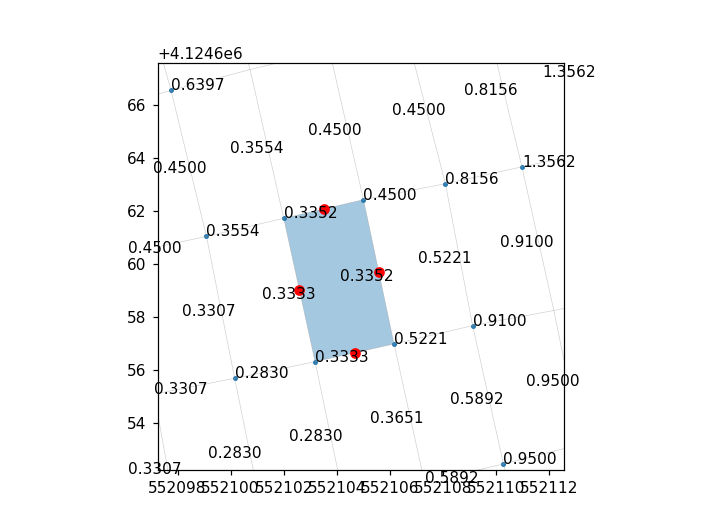

(552096.0, 552112.0, 4124651.3, 4124667.3)

In [476]:
fig,ax=plt.subplots(1,1)
g_local.plot_edges(color='0.6',lw=0.4,alpha=0.5)
g_local.plot_cells(mask=[c_local],alpha=0.4)
g_local.plot_edges(mask=g_local.cell_to_edges(cell),color='tab:blue')
plt.plot(flows.FlowLink_xu,flows.FlowLink_yu,'ro') # lines up. good.

# nodes=np.r_[350,356]-1
g_local.plot_nodes(clip=zoom,labeler=lambda i,rec: f"{ds['NetNode_z'].isel(nNetNode=i).values:.4f}",
                   sizes=5)
# g_local.plot_nodes(mask=nodes,color='g')
pad=8
zoom=[cell_center[0]-pad,cell_center[0]+pad,
      cell_center[1]-pad,cell_center[1]+pad]
ds=mu.dss[proc]
g_local.plot_cells(labeler=lambda c,rec: f"{ds['FlowElem_bl'].isel(nFlowElem=c).values:.4f}",
                   clip=zoom,color='none')
ax.axis(zoom)



In [360]:
# With bedlevtype=6, the node means gave the cell bl,
# and roughly it appeared that the average of the two
# cell bl gave the edge depth.
# np.mean([1.0184,1.0655,1.4509,1.4647]) # 1.24987
# np.mean([0.9179,1.0184,1.0655,0.9492]) # 0.9878
# 1.25-np.mean([0.9877,1.2499]) # 0.1312

# With bedlevtyp=5, looks like edges get the shallower of 
# the nodes, and cells get the deepest of the edges. that
# sounds safer.



# unorm and q1 implied this to be 
# dz=0.1346577

# Those are similar, but not within the realm of simple
# rounding error. The difference could be due to time
# staggering, if q1 is an integrated quantity and unorm
# is instantaneous. checked against integration from u0
# to unorm, but that is too small. Still, q1 could be 
# integrated from the previuos map output, or previous
# user timestep.

0.13119999999999998

In [410]:
(mu.FlowElem_bl.values % 0.25).max()

0.24999594201689046

In [301]:
ds['ucx'].isel(time=6,nFlowElem=cell)
(ds['timestep']/np.timedelta64(1,'s')).to_dataframe()

,timestep
time,
2016-05-20 00:00:00.000000000,1.000000
2016-05-20 00:05:00.000000000,0.012153
2016-05-20 00:10:00.000000000,0.067682
2016-05-20 00:15:00.000000000,0.089500
2016-05-20 00:20:00.000000000,0.054185
2016-05-20 00:25:00.000000000,0.160073
2016-05-20 00:30:00.000000000,0.052756
2016-05-20 00:30:01.884792193,0.000172


In [288]:
A=g11.cells_area(cell)
dz=1.25-ds['FlowElem_bl'].values[cell]
A*dz # 0.003 m3.
A*dz / 0.009 # CFL=1.0 for dt=0.35 s, at time=5 (goes nan at time=6)

0.3494632430102068

In [370]:
g11.cells_center()[cell]

array([ 552596.68886477, 4123806.9972321 ])

In [344]:
flows.isel(laydim=5,nFlowLink=3), u_edge.isel(laydim=5,nFlowLink=3)

(<xarray.DataArray 'q1' ()>
 array(0.008824)
 Coordinates:
     FlowLink_xu  float64 5.526e+05
     FlowLink_yu  float64 4.124e+06
     time         datetime64[ns] 2016-05-20T00:25:00
 Attributes:
     long_name:  flow flux
     units:      m3 s-1,
 <xarray.DataArray 'unorm' ()>
 array(0.009215)
 Coordinates:
     FlowLink_xu  float64 5.526e+05
     FlowLink_yu  float64 4.124e+06
     time         datetime64[ns] 2016-05-20T00:25:00
 Attributes:
     long_name:     normal component of sea_water_speed
     units:         m s-1
     grid_mapping:  projected_coordinate_system)

In [345]:
# Testing for consistency of layer thickness.
A_hor = (flows/u_edge).isel(laydim=5,nFlowLink=3)
A_hor # 0.9576 m2.
# This edge should be about 7m long.
# This doesn't square. That would make the thickness of the
# flux face 
# A_hor.values/g11.edges_length(g11.cell_to_edges(cell)[3])
# = 0.1346577m.
# Based on the bedlevel and the layer interfaces, it should be
# 0.0001 m thick.
# Check back on bedlevtype=6 and the adjacent node values.
# Adjacent node values if used directly would give 1.06 to 1.08
#ds['ww1'].isel(time=5,nFlowElem=cell,wdim=6).values * A / (u_edge.isel(laydim=5,nFlowLink=3).values

<xarray.DataArray ()>
array(0.95757175)
Coordinates:
    FlowLink_xu  float64 5.526e+05
    FlowLink_yu  float64 4.124e+06
    time         datetime64[ns] 2016-05-20T00:25:00

In [368]:
j_length=g11.edges_length(g11.cell_to_edges(cell)[3])

dz_est=(flows/u_edge).isel(laydim=5,nFlowLink=3).values/j_length
dz_est

0.13465137191275645

In [346]:
netlinks=g11.cell_to_edges(cell)
netlinks,flowlinks
jnet=netlinks[3]
nodes=ds.NetLink.isel(nNetLink=jnet).values # 1-based, NetNode 350 356, confirms with NetElemNode[cell]

ds.NetNode_z.isel(nNetNode=nodes-1)
# That gives 1.0183, 1.0655.

ds.FlowElem_zcc.isel(nFlowElem=cell) # depth matching elevation of FlowElem_bl

<xarray.DataArray 'FlowElem_zcc' ()>
array(-1.249898)
Coordinates:
    FlowElem_xcc  float64 5.526e+05
    FlowElem_ycc  float64 4.124e+06
Attributes:
    standard_name:  bed_level
    long_name:      bed level of flow element

In [339]:
ds

<xarray.Dataset>
Dimensions:                      (laydim: 14, nBndLink: 390, nFlowElem: 5621, nFlowElemContourPts: 4, nFlowLink: 8613, nFlowLinkPts: 2, nNetElem: 5621, nNetElemMaxNode: 4, nNetLink: 9003, nNetLinkContourPts: 4, nNetLinkPts: 2, nNetNode: 3384, nmesh2d_EnclosureInstance: 1, nmesh2d_EnclosureParts: 2, nmesh2d_EnclosurePoints: 305, time: 8, wdim: 15)
Coordinates:
    NetNode_x                    (nNetNode) float64 5.528e+05 ... 5.526e+05
    NetNode_y                    (nNetNode) float64 4.124e+06 ... 4.124e+06
    FlowElem_xcc                 (nFlowElem) float64 5.526e+05 ... 5.525e+05
    FlowElem_ycc                 (nFlowElem) float64 4.124e+06 ... 4.124e+06
    FlowLink_xu                  (nFlowLink) float64 5.526e+05 ... 5.525e+05
    FlowLink_yu                  (nFlowLink) float64 4.124e+06 ... 4.124e+06
  * time                         (time) datetime64[ns] 2016-05-20 ... 2016-05...
Dimensions without coordinates: laydim, nBndLink, nFlowElem, nFlowElemContourPts, nFlowLink, nFlowLinkPts, nNetElem, nNetElemMaxNode, nNetLink, nNetLinkContourPts, nNetLinkPts, nNetNode, nmesh2d_EnclosureInstance, nmesh2d_EnclosureParts, nmesh2d_EnclosurePoints, wdim
Data variables:
    mesh2d_enc_x                 (nmesh2d_EnclosurePoints) float64 5.526e+05 ...
    mesh2d_enc_y                 (nmesh2d_EnclosurePoints) float64 4.124e+06 ...
    mesh2d_enc_node_count        (nmesh2d_EnclosureInstance) int32 305
    mesh2d_enc_part_node_count   (nmesh2d_EnclosureParts) int32 190 115
    mesh2d_enc_interior_ring     (nmesh2d_EnclosureParts) int32 0 1
    mesh2d_enclosure_container   float32 9.969e+36
    Mesh2D                       int32 -2147483647
    projected_coordinate_system  int32 -2147483647
    NetNode_z                    (nNetNode) float64 2.17 2.169 ... 1.723 1.47
    NetLink                      (nNetLink, nNetLinkPts) int32 3320 3321 ... 915
    NetLinkType                  (nNetLink) int32 2 2 2 2 2 2 2 ... 2 2 2 2 2 2
    NetElemNode                  (nNetElem, nNetElemMaxNode) float64 3.32e+03...
    NetElemLink                  (nNetElem, nNetElemMaxNode) int32 1 ... -214...
    NetLinkContour_x             (nNetLink, nNetLinkContourPts) float64 5.526...
    NetLinkContour_y             (nNetLink, nNetLinkContourPts) float64 4.124...
    NetLink_xu                   (nNetLink) float64 5.526e+05 ... 5.525e+05
    NetLink_yu                   (nNetLink) float64 4.124e+06 ... 4.124e+06
    BndLink                      (nBndLink) int32 1 5 10 15 ... 8997 9001 9002
    FlowElem_zcc                 (nFlowElem) float64 -2.359 -2.384 ... -3.788
    FlowElem_bac                 (nFlowElem) float64 15.35 18.48 ... 11.67 15.57
    FlowElem_xzw                 (nFlowElem) float64 5.526e+05 ... 5.525e+05
    FlowElem_yzw                 (nFlowElem) float64 4.124e+06 ... 4.124e+06
    FlowElemContour_x            (nFlowElem, nFlowElemContourPts) float64 5.5...
    FlowElemContour_y            (nFlowElem, nFlowElemContourPts) float64 4.1...
    FlowElem_bl                  (nFlowElem) float64 2.359 2.384 ... 3.619 3.788
    ElemLink                     (nNetLink, nNetLinkPts) int32 1 0 ... 5621 5620
    FlowLink                     (nFlowLink, nFlowLinkPts) int32 1 2 ... 5620
    FlowLinkType                 (nFlowLink) int32 2 2 2 2 2 2 2 ... 2 2 2 2 2 2
    FlowLink_lonu                (nFlowLink) float64 9.969e+36 ... 9.969e+36
    FlowLink_latu                (nFlowLink) float64 9.969e+36 ... 9.969e+36
    FlowElemDomain               (nFlowElem) int32 11 11 11 11 ... 10 10 10 10
    FlowLinkDomain               (nFlowLink) int32 11 11 11 11 ... 11 11 11 11
    FlowElemGlobalNr             (nFlowElem) int32 48684 48687 ... 26776 26775
    LayCoord_cc                  (laydim) float64 9.969e+36 ... 9.969e+36
    LayCoord_w                   (wdim) float64 9.969e+36 ... 9.969e+36
    timestep                     (time) timedelta64[ns] 00:00:01 ... 00:00:00...
    s1                           (time, nFlowElem) float64 2.3

In [328]:
ds.

<xarray.Dataset>
Dimensions:                      (laydim: 14, nBndLink: 390, nFlowElem: 5621, nFlowElemContourPts: 4, nFlowLink: 8613, nFlowLinkPts: 2, nNetElem: 5621, nNetElemMaxNode: 4, nNetLink: 9003, nNetLinkContourPts: 4, nNetLinkPts: 2, nNetNode: 3384, nmesh2d_EnclosureInstance: 1, nmesh2d_EnclosureParts: 2, nmesh2d_EnclosurePoints: 305, time: 8, wdim: 15)
Coordinates:
    NetNode_x                    (nNetNode) float64 5.528e+05 ... 5.526e+05
    NetNode_y                    (nNetNode) float64 4.124e+06 ... 4.124e+06
    FlowElem_xcc                 (nFlowElem) float64 5.526e+05 ... 5.525e+05
    FlowElem_ycc                 (nFlowElem) float64 4.124e+06 ... 4.124e+06
    FlowLink_xu                  (nFlowLink) float64 5.526e+05 ... 5.525e+05
    FlowLink_yu                  (nFlowLink) float64 4.124e+06 ... 4.124e+06
  * time                         (time) datetime64[ns] 2016-05-20 ... 2016-05...
Dimensions without coordinates: laydim, nBndLink, nFlowElem, nFlowElemContourPts, nFlowLink, nFlowLinkPts, nNetElem, nNetElemMaxNode, nNetLink, nNetLinkContourPts, nNetLinkPts, nNetNode, nmesh2d_EnclosureInstance, nmesh2d_EnclosureParts, nmesh2d_EnclosurePoints, wdim
Data variables:
    mesh2d_enc_x                 (nmesh2d_EnclosurePoints) float64 5.526e+05 ...
    mesh2d_enc_y                 (nmesh2d_EnclosurePoints) float64 4.124e+06 ...
    mesh2d_enc_node_count        (nmesh2d_EnclosureInstance) int32 305
    mesh2d_enc_part_node_count   (nmesh2d_EnclosureParts) int32 190 115
    mesh2d_enc_interior_ring     (nmesh2d_EnclosureParts) int32 0 1
    mesh2d_enclosure_container   float32 9.969e+36
    Mesh2D                       int32 -2147483647
    projected_coordinate_system  int32 -2147483647
    NetNode_z                    (nNetNode) float64 2.17 2.169 ... 1.723 1.47
    NetLink                      (nNetLink, nNetLinkPts) int32 3320 3321 ... 915
    NetLinkType                  (nNetLink) int32 2 2 2 2 2 2 2 ... 2 2 2 2 2 2
    NetElemNode                  (nNetElem, nNetElemMaxNode) float64 3.32e+03...
    NetElemLink                  (nNetElem, nNetElemMaxNode) int32 1 ... -214...
    NetLinkContour_x             (nNetLink, nNetLinkContourPts) float64 5.526...
    NetLinkContour_y             (nNetLink, nNetLinkContourPts) float64 4.124...
    NetLink_xu                   (nNetLink) float64 5.526e+05 ... 5.525e+05
    NetLink_yu                   (nNetLink) float64 4.124e+06 ... 4.124e+06
    BndLink                      (nBndLink) int32 1 5 10 15 ... 8997 9001 9002
    FlowElem_zcc                 (nFlowElem) float64 -2.359 -2.384 ... -3.788
    FlowElem_bac                 (nFlowElem) float64 15.35 18.48 ... 11.67 15.57
    FlowElem_xzw                 (nFlowElem) float64 5.526e+05 ... 5.525e+05
    FlowElem_yzw                 (nFlowElem) float64 4.124e+06 ... 4.124e+06
    FlowElemContour_x            (nFlowElem, nFlowElemContourPts) float64 5.5...
    FlowElemContour_y            (nFlowElem, nFlowElemContourPts) float64 4.1...
    FlowElem_bl                  (nFlowElem) float64 2.359 2.384 ... 3.619 3.788
    ElemLink                     (nNetLink, nNetLinkPts) int32 1 0 ... 5621 5620
    FlowLink                     (nFlowLink, nFlowLinkPts) int32 1 2 ... 5620
    FlowLinkType                 (nFlowLink) int32 2 2 2 2 2 2 2 ... 2 2 2 2 2 2
    FlowLink_lonu                (nFlowLink) float64 9.969e+36 ... 9.969e+36
    FlowLink_latu                (nFlowLink) float64 9.969e+36 ... 9.969e+36
    FlowElemDomain               (nFlowElem) int32 11 11 11 11 ... 10 10 10 10
    FlowLinkDomain               (nFlowLink) int32 11 11 11 11 ... 11 11 11 11
    FlowElemGlobalNr             (nFlowElem) int32 48684 48687 ... 26776 26775
    LayCoord_cc                  (laydim) float64 9.969e+36 ... 9.969e+36
    LayCoord_w                   (wdim) float64 9.969e+36 ... 9.969e+36
    timestep                     (time) timedelta64[ns] 00:00:01 ... 00:00:00...
    s1                           (time, nFlowElem) float64 2.3

In [77]:
recs=[]

if 'laydim' in mu.dims:
    nlayer=mu.dims['laydim']
    layer_kw={'laydim':0}
else:
    layer_kw={}
    nlayer=0
    
salt_thresh=34
for t in utils.progress(range(mu.dss[0].dims['time'])):
    if nlayer<2:
        t_max=np.max(mu['tem1'].isel(time=t,**layer_kw))
        s_max=np.max(mu['sa1'].isel(time=t,**layer_kw))
        # print(f"t={t:4d}:  max T={t_max:8.3f}  max s={s_max:8.3f}")
        excess_salt=( (mu['sa1'].isel(time=t,**layer_kw).values-salt_thresh).clip(0) 
                      * mu['waterdepth'].isel(time=t) * mu['FlowElem_bac']).sum()
    else:
        # proper 3D 
        wet=np.isfinite(mu['ucx'].isel(time=t).values)
        T=mu['tem1'].isel(time=t).values
        t_max=T[wet].max()
        salt=mu['sa1'].isel(time=t).values
        s_max=salt[wet].max()
        # print(f"t={t:4d}:  max T={t_max:8.3f}  max s={s_max:8.3f}")
        excess_salt=0.0 # not ready for this calc 
    recs.append(dict(t=t,T_max=t_max,s_max=s_max,excess_salt=excess_salt))


INFO:utils:117/122


<IPython.core.display.Javascript object>


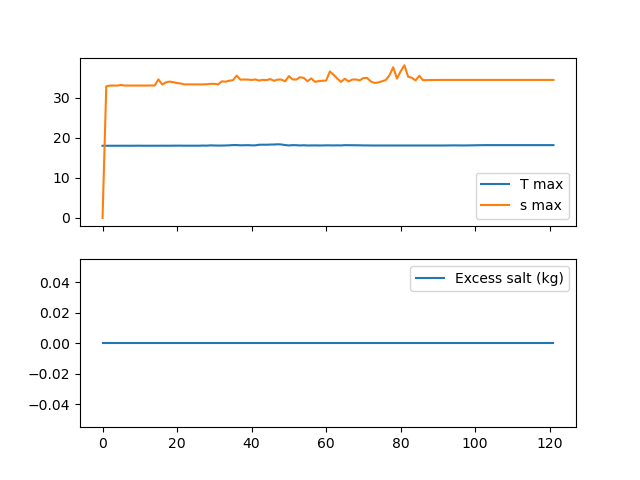

In [78]:
import pandas as pd
df=pd.DataFrame(recs)

fig,axs=plt.subplots(2,1,sharex=True)

axs[0].plot(df.t,df.T_max,label='T max')
axs[0].plot(df.t,df.s_max,label='s max')
axs[0].legend()

axs[1].plot(df.t,df.excess_salt,label='Excess salt (kg)')
axs[1].legend()

In [173]:
# Try to infer z layer structure:

# We have bedlevel, water level, nan ucx in cells below the bed,
# and I think also for cells above the water surface.

t=2

nlayers=mu.dims['laydim']
dzmin=np.inf

z_laymaxs=np.inf*np.ones(nlayers) # upper limit of layer

all_ucx=mu['ucx'].isel(time=t).values
all_s1=mu['s1'].isel(time=t).values
all_bl=mu['FlowElem_bl'].values

for c in utils.progress(range(mu.grid.Ncells())):
    s1=all_s1[c]
    bl=all_bl[c]
    dzmin=min(dzmin,s1-bl)

    wet_layers=np.isfinite(all_ucx[c,:])

    # This watercolumn bed is at 0.2793.
    # and the bottom 4 layers are empty.
    # so the upper interface of layer=3 is not above
    # 0.2793.
    z_laymaxs[~wet_layers]=np.minimum(z_laymaxs[~wet_layers],bl)

# That seems to work okay. Get interface locations, and nothing
# for the top of the last layer.
z_laymaxs

array([ 0.        ,  0.2514636 ,  0.50052367,  0.75087954,  1.        ,
        1.25005653,  1.50004267, -0.02828613, -0.22637939, -0.22637939,
       -0.22637939, -0.22637939, -0.22637939, -0.22637939])

In [133]:
dz=np.median(np.diff(z_laymaxs))
z_bot=z_laymaxs[0]-dz
z_top=z_laymaxs[-2]+dz
print(f"Inferred dz={dz:.5f}  z_bot={z_bot:.4f}   z_top={z_top:.4f}")
# That z_bot is pretty close to the deepest cell in the domain at 
# -0.22637 m, and the z_top is the initial water level
# of 1.4981

Inferred dz=0.12315  z_bot=-0.2240   z_top=1.4981


In [66]:
mu.reload()

<IPython.core.display.Javascript object>


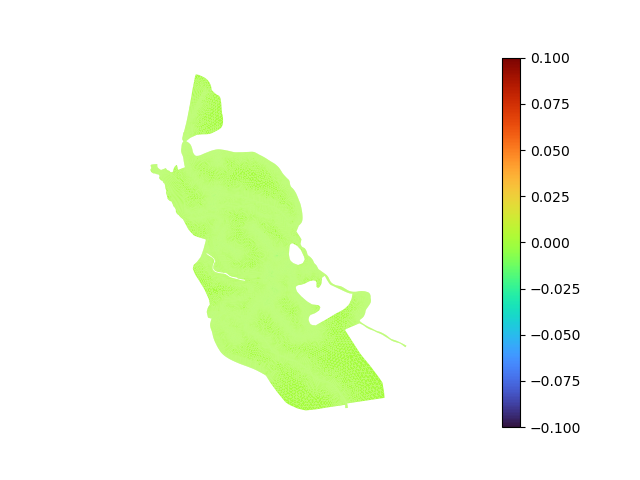

(551974.9643212383, 554166.6901515109, 4122619.5656163436, 4125496.2586278315)

In [243]:
plt.figure()

#mu.grid.plot_edges(lw=0.5,color='k',alpha=0.4)
ccoll=mu.grid.plot_cells(values=mu['sa1'].isel(time=-1),cmap='turbo')
plt.colorbar(ccoll)
plt.axis('off')
plt.axis('tight')
plt.axis('equal')
#plt.axis((551938.0292926112, 552765.2786743934, 4124006.5426040255, 4124777.0853749597))

In [174]:
# What?! his file is now split across domains?
his_fn=os.path.join( os.path.dirname(mu.paths[0]), 'flowfm_0000_his.nc')

In [175]:
his_ds=xr.open_dataset(his_fn)

In [178]:
his_ds

<xarray.Dataset>
Dimensions:                                  (cross_section: 10, gategens: 4, laydim: 14, laydimw: 15, nFlowElemContourPts: 4, nFlowElemWithBnd: 5366, nFlowLink: 8392, nFlowLinkPts: 2, nNetLink: 8627, nNetLinkPts: 2, station_geom_nNodes: 15, stations: 15, time: 8)
Coordinates:
    station_x_coordinate                     (stations) float64 5.526e+05 ......
    station_y_coordinate                     (stations) float64 4.124e+06 ......
    station_name                             (stations) |S64 b'pch_up' ... b'...
    zcoordinate_c                            (time, stations, laydim) float64 ...
    zcoordinate_w                            (time, stations, laydimw) float64 ...
    zcoordinate_wu                           (time, stations, laydimw) float64 ...
    cross_section_name                       (cross_section) |S64 b'mouth_xs'...
    gategen_name                             (gategens) |S64 b'pch_gate' ... ...
  * time                                     (time) datetime64[ns] 2016-05-20...
Dimensions without coordinates: cross_section, gategens, laydim, laydimw, nFlowElemContourPts, nFlowElemWithBnd, nFlowLink, nFlowLinkPts, nNetLink, nNetLinkPts, station_geom_nNodes, stations
Data variables:
    FlowElem_xcc                             (nFlowElemWithBnd) float64 5.53e...
    FlowElem_ycc                             (nFlowElemWithBnd) float64 4.124...
    FlowElem_zcc                             (nFlowElemWithBnd) float64 -2.33...
    FlowElem_bac                             (nFlowElemWithBnd) float64 10.25...
    FlowElem_xzw                             (nFlowElemWithBnd) float64 5.53e...
    FlowElem_yzw                             (nFlowElemWithBnd) float64 4.124...
    FlowElemContour_x                        (nFlowElemWithBnd, nFlowElemContourPts) float64 ...
    FlowElemContour_y                        (nFlowElemWithBnd, nFlowElemContourPts) float64 ...
    FlowElem_bl                              (nFlowElemWithBnd) float64 2.333...
    ElemLink                                 (nNetLink, nNetLinkPts) int32 1 ...
    FlowLink                                 (nFlowLink, nFlowLinkPts) int32 ...
    FlowLinkType                             (nFlowLink) int32 2 2 2 2 ... 2 2 2
    FlowLink_xu                              (nFlowLink) float64 5.53e+05 ......
    FlowLink_yu                              (nFlowLink) float64 4.124e+06 .....
    projected_coordinate_system              int32 -2147483647
    FlowLink_lonu                            (nFlowLink) float64 9.969e+36 .....
    FlowLink_latu                            (nFlowLink) float64 9.969e+36 .....
    FlowElemDomain                           (nFlowElemWithBnd) int32 2 2 ... 0
    FlowLinkDomain                           (nFlowLink) int32 0 0 0 0 ... 0 0 0
    FlowElemGlobalNr                         (nFlowElemWithBnd) int32 46483 ....
    station_id                               (stations) |S64 b'pch_up' ... b'...
    station_geom                             int32 -2147483647
    station_geom_node_count                  (stations) int32 1 1 1 1 ... 1 1 1
    station_geom_node_coordx                 (station_geom_nNodes) float64 5....
    station_geom_node_coordy                 (station_geom_nNodes) float64 4....
    waterlevel                               (time, stations) float64 1.498 ....
    bedlevel                                 (stations) float64 0.9118 ... 0....
    x_velocity                               (time, stations, laydim) float64 ...
    y_velocity                               (time, stations, laydim) float64 ...
    z_velocity                               (time, stations, laydim) float64 ...
    depth-averaged_x_velocity                (time, stations) float64 0.0 ......
    depth-averaged_y_velocity                (time, stations) float64 0.0 ......
    tke                                      (time, stations, laydimw) float64 ...
    vicww                                    (time, stations, laydimw) float64 ...
    eps  

In [189]:
# History file has more information on z coordinates
# zcoordinate_c gives elevation of the vertical center
# of the layers, on a time and cell basis.
his_ds.zcoordinate_w.isel(time=4,stations=5)

<xarray.DataArray 'zcoordinate_w' (laydimw: 15)>
array([     nan,      nan,      nan,      nan,      nan, 1.166851, 1.25    ,
       1.5     , 1.52168 ,      nan,      nan,      nan,      nan,      nan,
            nan])
Coordinates:
    station_x_coordinate  float64 5.528e+05
    station_y_coordinate  float64 4.124e+06
    station_name          |S64 b'ch2'
    zcoordinate_w         (laydimw) float64 nan nan nan nan ... nan nan nan nan
    zcoordinate_wu        (laydimw) float64 nan nan nan nan ... nan nan nan nan
    time                  datetime64[ns] 2016-05-20T00:20:00
Dimensions without coordinates: laydimw
Attributes:
    long_name:     vertical coordinate at centre of flow element and at layer...
    units:         m
    grid_mapping:  projected_coordinate_system
    geometry:      station_geom
    positive:      up

In [488]:
mu.paths[0]

'run_salt_20160520-v44/DFM_OUTPUT_flowfm/flowfm_0000_map.nc'

In [507]:
# See if there is useful crash data in the last restart file
p=0
ds=xr.open_dataset(f'run_salt_20160520-v44/DFM_OUTPUT_flowfm/flowfm_{p:04d}_20160520_002809_rst.nc')

In [491]:
ds

<xarray.Dataset>
Dimensions:           (laydim: 14, nFlowElem: 5301, nFlowLink: 8188, nFlowLinkPts: 2, nNetElem: 5301, nNetElemMaxNode: 4, nNetLink: 8430, nNetLinkPts: 2, time: 1, wdim: 15)
Coordinates:
  * time              (time) datetime64[ns] 2016-05-20T00:28:09.776995709
    FlowLink_xu       (nFlowLink) float64 ...
    FlowLink_yu       (nFlowLink) float64 ...
Dimensions without coordinates: laydim, nFlowElem, nFlowLink, nFlowLinkPts, nNetElem, nNetElemMaxNode, nNetLink, nNetLinkPts, wdim
Data variables:
    timestep          (time) timedelta64[ns] ...
    s1                (time, nFlowElem) float64 ...
    s0                (time, nFlowElem) float64 ...
    taus              (time, nFlowElem) float64 ...
    czs               (time, nFlowElem) float64 ...
    FlowElem_bl       (time, nFlowElem) float64 ...
    unorm             (time, nFlowLink, laydim) float64 ...
    u0                (time, nFlowLink, laydim) float64 ...
    q1                (time, nFlowLink, laydim) float64 ...
    ucx               (time, nFlowElem, laydim) float64 ...
    ucy               (time, nFlowElem, laydim) float64 ...
    ucz               (time, nFlowElem, laydim) float64 ...
    ww1               (time, nFlowElem, wdim) float64 ...
    unorm_averaged    (time, nFlowLink) float64 ...
    qw                (time, nFlowElem, wdim) float64 ...
    qa                (time, nFlowLink, laydim) float64 ...
    sqi               (time, nFlowElem, wdim) float64 ...
    squ               (time, nFlowElem, wdim) float64 ...
    vicwwu            (time, nFlowLink, wdim) float64 ...
    turkin1           (time, nFlowLink, wdim) float64 ...
    tureps1           (time, nFlowLink, wdim) float64 ...
    sa1               (time, nFlowElem, laydim) float64 ...
    tem1              (time, nFlowElem, laydim) float64 ...
    FlowElem_xzw      (nFlowElem) float64 ...
    FlowElem_yzw      (nFlowElem) float64 ...
    FlowElemDomain    (nFlowElem) int32 ...
    FlowElemGlobalNr  (nFlowElem) int32 ...
    FlowLink          (nFlowLink, nFlowLinkPts) int32 ...
    NetElemNode       (nNetElem, nNetElemMaxNode) float64 ...
    NetLink           (nNetLink, nNetLinkPts) int32 ...
Attributes:
    institution:    Deltares
    references:     http://www.deltares.nl
    source:         Deltares, D-Flow FM Version 1.2.110.67911, Nov 04 2020, 2...
    history:        Created on 2021-05-14T10:33:59-0700, D-Flow FM
    date_created:   2021-05-14T10:33:59-0700
    date_modified:  2021-05-14T10:33:59-0700
    Conventions:    CF-1.5 Deltares-0.1

In [492]:
ds.timestep.values/np.timedelta64(1,'s') # 0.00033 s
# squ is the cell-centerd outgoing flux.  seems useful.

array([0.00033507])

In [504]:
squ[squ==-999]=np.nan

In [500]:
np.nanmax(squ),np.nanmin(squ) # 0.2822, 0.0

(0.28227504729019265, 0.0)

<IPython.core.display.Javascript object>


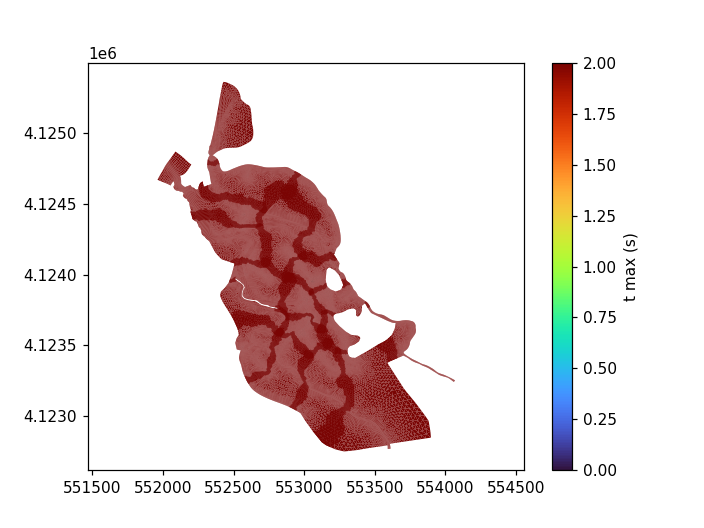

0
Min(t_max): 15.297114823571617
1


<ipython-input-540-2e0669551dac>:15: RuntimeWarning: divide by zero encountered in true_divide
  t_max=np.where(squ_zsum>0, Vc/squ_zsum, 1e3)
<ipython-input-540-2e0669551dac>:15: RuntimeWarning: invalid value encountered in true_divide
  t_max=np.where(squ_zsum>0, Vc/squ_zsum, 1e3)
<ipython-input-540-2e0669551dac>:15: RuntimeWarning: divide by zero encountered in true_divide
  t_max=np.where(squ_zsum>0, Vc/squ_zsum, 1e3)
<ipython-input-540-2e0669551dac>:15: RuntimeWarning: invalid value encountered in true_divide
  t_max=np.where(squ_zsum>0, Vc/squ_zsum, 1e3)


Min(t_max): 11.940527031059247
2
Min(t_max): 19.446427044704556
3


<ipython-input-540-2e0669551dac>:15: RuntimeWarning: divide by zero encountered in true_divide
  t_max=np.where(squ_zsum>0, Vc/squ_zsum, 1e3)
<ipython-input-540-2e0669551dac>:15: RuntimeWarning: invalid value encountered in true_divide
  t_max=np.where(squ_zsum>0, Vc/squ_zsum, 1e3)
<ipython-input-540-2e0669551dac>:15: RuntimeWarning: divide by zero encountered in true_divide
  t_max=np.where(squ_zsum>0, Vc/squ_zsum, 1e3)
<ipython-input-540-2e0669551dac>:15: RuntimeWarning: invalid value encountered in true_divide
  t_max=np.where(squ_zsum>0, Vc/squ_zsum, 1e3)


Min(t_max): 12.79886438399375
4
Min(t_max): 5.91753588701551
5


<ipython-input-540-2e0669551dac>:15: RuntimeWarning: divide by zero encountered in true_divide
  t_max=np.where(squ_zsum>0, Vc/squ_zsum, 1e3)
<ipython-input-540-2e0669551dac>:15: RuntimeWarning: invalid value encountered in true_divide
  t_max=np.where(squ_zsum>0, Vc/squ_zsum, 1e3)
<ipython-input-540-2e0669551dac>:15: RuntimeWarning: divide by zero encountered in true_divide
  t_max=np.where(squ_zsum>0, Vc/squ_zsum, 1e3)
<ipython-input-540-2e0669551dac>:15: RuntimeWarning: invalid value encountered in true_divide
  t_max=np.where(squ_zsum>0, Vc/squ_zsum, 1e3)


Min(t_max): 10.983603812504592
6
Min(t_max): 28.16892374052498
7


<ipython-input-540-2e0669551dac>:15: RuntimeWarning: divide by zero encountered in true_divide
  t_max=np.where(squ_zsum>0, Vc/squ_zsum, 1e3)
<ipython-input-540-2e0669551dac>:15: RuntimeWarning: invalid value encountered in true_divide
  t_max=np.where(squ_zsum>0, Vc/squ_zsum, 1e3)
<ipython-input-540-2e0669551dac>:15: RuntimeWarning: divide by zero encountered in true_divide
  t_max=np.where(squ_zsum>0, Vc/squ_zsum, 1e3)
<ipython-input-540-2e0669551dac>:15: RuntimeWarning: invalid value encountered in true_divide
  t_max=np.where(squ_zsum>0, Vc/squ_zsum, 1e3)


Min(t_max): 8.701109206101753
8
Min(t_max): 23.05855937717142
9


<ipython-input-540-2e0669551dac>:15: RuntimeWarning: divide by zero encountered in true_divide
  t_max=np.where(squ_zsum>0, Vc/squ_zsum, 1e3)
<ipython-input-540-2e0669551dac>:15: RuntimeWarning: invalid value encountered in true_divide
  t_max=np.where(squ_zsum>0, Vc/squ_zsum, 1e3)
<ipython-input-540-2e0669551dac>:15: RuntimeWarning: divide by zero encountered in true_divide
  t_max=np.where(squ_zsum>0, Vc/squ_zsum, 1e3)
<ipython-input-540-2e0669551dac>:15: RuntimeWarning: invalid value encountered in true_divide
  t_max=np.where(squ_zsum>0, Vc/squ_zsum, 1e3)


Min(t_max): 43.221070743929296
10
Min(t_max): 19.982682497214974
11


<ipython-input-540-2e0669551dac>:15: RuntimeWarning: divide by zero encountered in true_divide
  t_max=np.where(squ_zsum>0, Vc/squ_zsum, 1e3)
<ipython-input-540-2e0669551dac>:15: RuntimeWarning: invalid value encountered in true_divide
  t_max=np.where(squ_zsum>0, Vc/squ_zsum, 1e3)
<ipython-input-540-2e0669551dac>:15: RuntimeWarning: divide by zero encountered in true_divide
  t_max=np.where(squ_zsum>0, Vc/squ_zsum, 1e3)
<ipython-input-540-2e0669551dac>:15: RuntimeWarning: invalid value encountered in true_divide
  t_max=np.where(squ_zsum>0, Vc/squ_zsum, 1e3)


Min(t_max): 19.47529070361854
12


<ipython-input-540-2e0669551dac>:15: RuntimeWarning: invalid value encountered in true_divide
  t_max=np.where(squ_zsum>0, Vc/squ_zsum, 1e3)


Min(t_max): 1000.0
13
Min(t_max): 1000.0
14


<ipython-input-540-2e0669551dac>:15: RuntimeWarning: invalid value encountered in true_divide
  t_max=np.where(squ_zsum>0, Vc/squ_zsum, 1e3)
<ipython-input-540-2e0669551dac>:15: RuntimeWarning: divide by zero encountered in true_divide
  t_max=np.where(squ_zsum>0, Vc/squ_zsum, 1e3)
<ipython-input-540-2e0669551dac>:15: RuntimeWarning: invalid value encountered in true_divide
  t_max=np.where(squ_zsum>0, Vc/squ_zsum, 1e3)


Min(t_max): 159.8015419725105
15
Min(t_max): 1000.0


<ipython-input-540-2e0669551dac>:15: RuntimeWarning: divide by zero encountered in true_divide
  t_max=np.where(squ_zsum>0, Vc/squ_zsum, 1e3)
<ipython-input-540-2e0669551dac>:15: RuntimeWarning: invalid value encountered in true_divide
  t_max=np.where(squ_zsum>0, Vc/squ_zsum, 1e3)


(551856.9727258877, 554172.3087989085, 4122619.5656163436, 4125496.2586278315)

In [540]:
# Calculate 2D CFL #s
plt.figure()
colls=[]
for p in range(len(mu.paths)):
    print(p)
    ds=xr.open_dataset(f'run_salt_20160520-v44/DFM_OUTPUT_flowfm/flowfm_{p:04d}_20160520_002809_rst.nc')
    g_p=unstructured_grid.UnstructuredGrid.read_ugrid(mu.dss[p])
    squ=ds.squ.values[0,:,:] # cell, wdim
    squ_zsum=np.sum(squ.clip(0),axis=1)
    # colls.append( g_p.plot_cells(values=squ_zsum,cmap='turbo',clim=[0,10]) )
    # normalize by cell area:
    Ac=g_p.cells_area()
    dz=ds.s1.values[0,:] - ds.FlowElem_bl.values[0,:]
    Vc=Ac*dz
    t_max=np.where(squ_zsum>0, Vc/squ_zsum, 1e3)
    colls.append( g_p.plot_cells(values=t_max,cmap='turbo',clim=[0,2]) )
    print("Min(t_max):",t_max.min())
    ds.close()

plt.colorbar(colls[0],label='t max (s)')
plt.axis('tight')
plt.axis('equal')

<IPython.core.display.Javascript object>


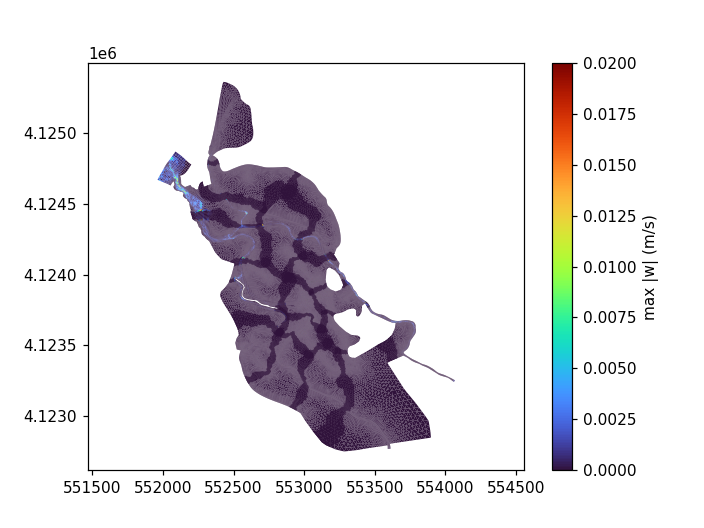

0
max w_absmax: 0.019370033686603023
min dt_max vertical (conservative):  2.765753403848023
1
max w_absmax: 0.020952913366375593
min dt_max vertical (conservative):  2.433729207138114
2
max w_absmax: 0.016986039678778955
min dt_max vertical (conservative):  3.4252000098715287
3


<ipython-input-568-28280a656495>:15: RuntimeWarning: divide by zero encountered in true_divide
  max_dt_vert=np.where(w_absmax>0,dz_surf/w_absmax,1e3)
<ipython-input-568-28280a656495>:15: RuntimeWarning: divide by zero encountered in true_divide
  max_dt_vert=np.where(w_absmax>0,dz_surf/w_absmax,1e3)
<ipython-input-568-28280a656495>:15: RuntimeWarning: invalid value encountered in true_divide
  max_dt_vert=np.where(w_absmax>0,dz_surf/w_absmax,1e3)
<ipython-input-568-28280a656495>:15: RuntimeWarning: divide by zero encountered in true_divide
  max_dt_vert=np.where(w_absmax>0,dz_surf/w_absmax,1e3)
<ipython-input-568-28280a656495>:15: RuntimeWarning: divide by zero encountered in true_divide
  max_dt_vert=np.where(w_absmax>0,dz_surf/w_absmax,1e3)


max w_absmax: 0.02544374486313634
min dt_max vertical (conservative):  2.4350332531187644
4
max w_absmax: 0.039157353131071486
min dt_max vertical (conservative):  1.3494571684923886
5
max w_absmax: 0.02283818298305542
min dt_max vertical (conservative):  2.78877341636936
6
max w_absmax: 0.006258528482092166
min dt_max vertical (conservative):  0.6531622375109732
7


<ipython-input-568-28280a656495>:15: RuntimeWarning: divide by zero encountered in true_divide
  max_dt_vert=np.where(w_absmax>0,dz_surf/w_absmax,1e3)
<ipython-input-568-28280a656495>:15: RuntimeWarning: divide by zero encountered in true_divide
  max_dt_vert=np.where(w_absmax>0,dz_surf/w_absmax,1e3)
<ipython-input-568-28280a656495>:15: RuntimeWarning: divide by zero encountered in true_divide
  max_dt_vert=np.where(w_absmax>0,dz_surf/w_absmax,1e3)
<ipython-input-568-28280a656495>:15: RuntimeWarning: divide by zero encountered in true_divide
  max_dt_vert=np.where(w_absmax>0,dz_surf/w_absmax,1e3)


max w_absmax: 0.022998769672117343
min dt_max vertical (conservative):  0.612304661988294
8
max w_absmax: 0.003762792628426797
min dt_max vertical (conservative):  0.6809389894345782
9
max w_absmax: 0.004813796418953498
min dt_max vertical (conservative):  0.8527060662547231
10
max w_absmax: 0.00980439970219467
min dt_max vertical (conservative):  2.820651527015552
11


<ipython-input-568-28280a656495>:15: RuntimeWarning: divide by zero encountered in true_divide
  max_dt_vert=np.where(w_absmax>0,dz_surf/w_absmax,1e3)
<ipython-input-568-28280a656495>:15: RuntimeWarning: divide by zero encountered in true_divide
  max_dt_vert=np.where(w_absmax>0,dz_surf/w_absmax,1e3)
<ipython-input-568-28280a656495>:15: RuntimeWarning: divide by zero encountered in true_divide
  max_dt_vert=np.where(w_absmax>0,dz_surf/w_absmax,1e3)
<ipython-input-568-28280a656495>:15: RuntimeWarning: divide by zero encountered in true_divide
  max_dt_vert=np.where(w_absmax>0,dz_surf/w_absmax,1e3)


max w_absmax: 0.017216831477190886
min dt_max vertical (conservative):  3.5067166298602213
12
max w_absmax: 0.0
min dt_max vertical (conservative):  1000.0
13
max w_absmax: 0.00012011328147186782
min dt_max vertical (conservative):  1000.0
14
max w_absmax: 0.0013744540753603152
min dt_max vertical (conservative):  7.299997335505404
15
max w_absmax: 2.587144856562583e-14
min dt_max vertical (conservative):  1000.0


<ipython-input-568-28280a656495>:15: RuntimeWarning: divide by zero encountered in true_divide
  max_dt_vert=np.where(w_absmax>0,dz_surf/w_absmax,1e3)
<ipython-input-568-28280a656495>:15: RuntimeWarning: divide by zero encountered in true_divide
  max_dt_vert=np.where(w_absmax>0,dz_surf/w_absmax,1e3)
<ipython-input-568-28280a656495>:15: RuntimeWarning: divide by zero encountered in true_divide
  max_dt_vert=np.where(w_absmax>0,dz_surf/w_absmax,1e3)
<ipython-input-568-28280a656495>:15: RuntimeWarning: divide by zero encountered in true_divide
  max_dt_vert=np.where(w_absmax>0,dz_surf/w_absmax,1e3)


(551856.9727258877, 554172.3087989085, 4122619.5656163436, 4125496.2586278315)

In [568]:
# Survey vertical velocity
plt.figure()
colls=[]
for p in range(len(mu.paths)):
    print(p)
    ds=xr.open_dataset(f'run_salt_20160520-v44/DFM_OUTPUT_flowfm/flowfm_{p:04d}_20160520_002809_rst.nc')
    g_p=unstructured_grid.UnstructuredGrid.read_ugrid(mu.dss[p])
    ww1=ds.ww1.isel(time=0).values # element, wdim
    ww1[ww1==-999]=np.nan
    w_absmax=np.nanmax(np.abs(ww1),axis=1)
    colls.append( g_p.plot_cells(values=w_absmax,cmap='turbo',clim=[0,0.02]) )
    print("max w_absmax:",w_absmax.max())
    # surface layer thickness
    dz_surf=ds.s1.isel(time=0).values %0.25
    max_dt_vert=np.where(w_absmax>0,dz_surf/w_absmax,1e3)
    print("min dt_max vertical (conservative): ",min(max_dt_vert))
    ds.close()

plt.colorbar(colls[0],label='max |w| (m/s)')
plt.axis('tight')
plt.axis('equal')

In [571]:
# Survey vertical viscosity
for p in range(len(mu.paths)):
    print(p)
    ds=xr.open_dataset(f'run_salt_20160520-v44/DFM_OUTPUT_flowfm/flowfm_{p:04d}_20160520_002809_rst.nc')
    vicwwu=ds.vicwwu.isel(time=0).values # flowlink, wdim
    print("max vicwwu:",np.nanmax(vicwwu))
    ds.close()


0
max vicwwu: 0.0008316735589796347
1
max vicwwu: 0.0010026244369355185
2
max vicwwu: 0.0007514430766461734
3
max vicwwu: 0.0011079951839001979
4
max vicwwu: 0.007284724720116316
5
max vicwwu: 0.0011079951839001979
6
max vicwwu: 0.00024622321425108796
7
max vicwwu: 0.0010026244369355246
8
max vicwwu: 0.00024991694222697855
9
max vicwwu: 0.0002886613183192298
10
max vicwwu: 0.0008932955105801862
11
max vicwwu: 0.0009975190322148997
12
max vicwwu: 0.0
13
max vicwwu: 1.1401266114793264e-07
14
max vicwwu: 2.746623096146002e-06
15
max vicwwu: 3.268786626008793e-08


In [569]:
ds

<xarray.Dataset>
Dimensions:           (laydim: 14, nFlowElem: 5571, nFlowLink: 8709, nFlowLinkPts: 2, nNetElem: 5571, nNetElemMaxNode: 4, nNetLink: 8997, nNetLinkPts: 2, time: 1, wdim: 15)
Coordinates:
  * time              (time) datetime64[ns] 2016-05-20T00:28:09.776995709
    FlowLink_xu       (nFlowLink) float64 ...
    FlowLink_yu       (nFlowLink) float64 ...
Dimensions without coordinates: laydim, nFlowElem, nFlowLink, nFlowLinkPts, nNetElem, nNetElemMaxNode, nNetLink, nNetLinkPts, wdim
Data variables:
    timestep          (time) timedelta64[ns] ...
    s1                (time, nFlowElem) float64 ...
    s0                (time, nFlowElem) float64 ...
    taus              (time, nFlowElem) float64 ...
    czs               (time, nFlowElem) float64 ...
    FlowElem_bl       (time, nFlowElem) float64 ...
    unorm             (time, nFlowLink, laydim) float64 ...
    u0                (time, nFlowLink, laydim) float64 ...
    q1                (time, nFlowLink, laydim) float64 ...
    ucx               (time, nFlowElem, laydim) float64 ...
    ucy               (time, nFlowElem, laydim) float64 ...
    ucz               (time, nFlowElem, laydim) float64 ...
    ww1               (time, nFlowElem, wdim) float64 ...
    unorm_averaged    (time, nFlowLink) float64 ...
    qw                (time, nFlowElem, wdim) float64 ...
    qa                (time, nFlowLink, laydim) float64 ...
    sqi               (time, nFlowElem, wdim) float64 ...
    squ               (time, nFlowElem, wdim) float64 ...
    vicwwu            (time, nFlowLink, wdim) float64 ...
    turkin1           (time, nFlowLink, wdim) float64 ...
    tureps1           (time, nFlowLink, wdim) float64 ...
    sa1               (time, nFlowElem, laydim) float64 ...
    tem1              (time, nFlowElem, laydim) float64 ...
    FlowElem_xzw      (nFlowElem) float64 ...
    FlowElem_yzw      (nFlowElem) float64 ...
    FlowElemDomain    (nFlowElem) int32 ...
    FlowElemGlobalNr  (nFlowElem) int32 ...
    FlowLink          (nFlowLink, nFlowLinkPts) int32 ...
    NetElemNode       (nNetElem, nNetElemMaxNode) float64 ...
    NetLink           (nNetLink, nNetLinkPts) int32 ...
Attributes:
    institution:    Deltares
    references:     http://www.deltares.nl
    source:         Deltares, D-Flow FM Version 1.2.110.67911, Nov 04 2020, 2...
    history:        Created on 2021-05-14T10:33:59-0700, D-Flow FM
    date_created:   2021-05-14T10:33:59-0700
    date_modified:  2021-05-14T10:33:59-0700
    Conventions:    CF-1.5 Deltares-0.1